# EE519 — Lecture 9 (Linear Prediction / LPC) — Notebook 9.5
## LP residual + LP spectrum for the **entire signal** (frame-by-frame)

**Theme:** Do LPC on every frame → build a *full-length* LP residual signal, and build an *LP-spectrum spectrogram* (time–frequency envelope).

> “All models are wrong, but some are useful.” — George Box


### 🎯 Learning goals
- Compute **LP residual** for *every frame* and reconstruct a **full-length residual waveform** (overlap-add)
- Listen: original vs residual (whole signal + selected vowel region)
- Compute **LP spectrum** (all-pole envelope) for *every frame*
- Visualize LP spectrum as a **2D ‘LP-spectrogram’** and an optional **3D surface**


## 0. Environment & imports (run this first)

This notebook uses:
- `numpy`, `matplotlib`
- `scipy` (signal + linalg)
- optional: `sounddevice` (recording)
- optional: `sklearn` (mini ML demo only)

If any import fails, the cell prints what to do next.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Core scipy imports (required)
try:
    import scipy.signal as sig
    import scipy.linalg as la
    import scipy.io.wavfile as wavfile
    SCIPY_OK = True
    print("scipy imports: ✅")
except Exception as e:
    SCIPY_OK = False
    print("scipy imports: ❌")
    print("Error:", e)

# Optional recording
try:
    import sounddevice as sd
    HAS_SD = True
    print("sounddevice: ✅ (recording enabled)")
except Exception as e:
    HAS_SD = False
    print("sounddevice: ❌ (recording disabled)")

from pathlib import Path
import json, os, time
from IPython.display import Audio, display


scipy imports: ✅
sounddevice: ✅ (recording enabled)


## 1. Project + manifest workflow (same spirit as Lectures 7/8)

We will use one project folder:
```
EE519_L9_Project/
  recordings/
  figures/
  features/
  cache/
  manifest.json
```

✅ You can re-run this cell any time safely.


In [2]:
PROJECT_DIR = Path("EE519_L9_Project")
REC_DIR = PROJECT_DIR / "recordings"
FIG_DIR = PROJECT_DIR / "figures"
FEAT_DIR = PROJECT_DIR / "features"
CACHE_DIR = PROJECT_DIR / "cache"

for d in [PROJECT_DIR, REC_DIR, FIG_DIR, FEAT_DIR, CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text())
    return {"clips": [], "meta": {"created": time.time(), "course":"EE519", "lecture":9}}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2))

manifest = load_manifest()
print("Manifest clips:", len(manifest["clips"]))
print("Project dir:", PROJECT_DIR.resolve())


Manifest clips: 9
Project dir: C:\Users\K\Documents\usc\ee519\ee519-lecture\lecture10\EE519_L9_Project


## 2. Utilities (audio I/O, framing, STFT, saving figures)

These helpers are used throughout Lecture 9 notebooks.


In [3]:
def read_wav(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float32)
    if x.ndim > 1:
        x = x.mean(axis=1)
    if np.max(np.abs(x)) > 1.5:
        x = x / 32768.0
    return fs, x

def peak_normalize(x, target=0.95):
    m = np.max(np.abs(x)) + 1e-12
    return x * (target / m)

def play_audio(x, fs, label=""):
    print(label, f"(fs={fs}, length={len(x)/fs:.2f}s)")
    display(Audio(x, rate=fs))

def savefig(name):
    out = FIG_DIR / name
    plt.savefig(out, dpi=180, bbox_inches="tight")
    print("Saved:", out)

def hann(N):
    return np.hanning(N).astype(np.float32)

def frame_signal(x, N, H):
    if len(x) < N:
        raise ValueError("Signal shorter than frame length N.")
    num = 1 + (len(x) - N) // H
    frames = np.stack([x[i*H:i*H+N] for i in range(num)], axis=0)
    return frames

def stft_scipy(x, fs, win_ms=25, hop_ms=10, nfft=None, window="hann"):
    N = int(win_ms * 1e-3 * fs)
    H = int(hop_ms * 1e-3 * fs)
    if nfft is None:
        nfft = 1 << int(np.ceil(np.log2(N)))
    f, t, Z = sig.stft(x, fs=fs, window=window, nperseg=N, noverlap=N-H, nfft=nfft, boundary=None, padded=False)
    return f, t, Z, N, H

def plot_spectrogram(sig_or_Z, fs, title, fmax=4000, win_ms=25, hop_ms=10, nfft=1024):
    """Plot STFT magnitude spectrogram.
    Accepts either:
      - waveform (1D) -> computes STFT
      - STFT matrix Z (2D: F x T)
    """
    Z = sig_or_Z
    if np.asarray(Z).ndim == 1:
        # waveform -> compute STFT (use our scipy STFT helper for consistency)
        f, t, Z, _, _ = stft_scipy(Z, fs, win_ms=win_ms, hop_ms=hop_ms, nfft=nfft)
        times = t
        freqs = f
    else:
        # assume STFT already
        freqs = np.linspace(0, fs/2, Z.shape[0])
        times = np.arange(Z.shape[1]) * (hop_ms * 1e-3)

    S = 20*np.log10(np.abs(Z) + 1e-12)

    plt.figure(figsize=(10,4))
    plt.imshow(S, origin="lower", aspect="auto",
               extent=[times[0], times[-1] if len(times)>1 else times[0] + 1e-6,
                       freqs[0], freqs[-1]])
    plt.ylim([0, min(fmax, fs/2)])
    plt.colorbar(label="dB")
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")


## LPC core functions (used in Notebooks 9.1–9.4)

### Important fix vs earlier versions
- `toeplitz` is in `scipy.linalg`, not `scipy.signal`.
- We therefore use `la.toeplitz` to avoid errors.

### Autocorrelation convention
We use a **biased** autocorrelation estimate:
\$
r[k] = \sum_{n=0}^{N-1-k} x[n]\,x[n+k]
\$

This is common in LPC autocorrelation method demonstrations.


In [5]:
def autocorr_biased(x, p):
    x = np.asarray(x, dtype=np.float64)
    r = np.zeros(p+1, dtype=np.float64)
    for k in range(p+1):
        r[k] = np.sum(x[:len(x)-k] * x[k:])
    return r

def lpc_autocorr_method(x, p):
    r = autocorr_biased(x, p)
    R = la.toeplitz(r[:-1])  # r[0..p-1]
    rhs = -r[1:]
    a = np.linalg.solve(R + 1e-12*np.eye(p), rhs)
    return a, r

def lpc_residual(x, a):
    A = np.concatenate([[1.0], a])
    e = sig.lfilter(A, [1.0], x)
    return e

def lpc_envelope_db(a, fs, nfft=4096):
    A = np.concatenate([[1.0], a])
    # Use freqz (stable, consistent)
    w, h = sig.freqz([1.0], A, worN=nfft, fs=fs)
    env_db = 20*np.log10(np.abs(h)+1e-12)
    return w, env_db

def fft_mag_db(x, fs, nfft=4096):
    X = np.fft.rfft(x, n=nfft)
    f = np.fft.rfftfreq(nfft, 1/fs)
    mag_db = 20*np.log10(np.abs(X)+1e-12)
    return f, mag_db

def normalize_to_peak(y_db):
    return y_db - np.max(y_db)


## 2. Load a clip (choose by label or filename)
This is the same `manifest.json` workflow as Notebook 9.0, but you can choose the clip more flexibly.

In [6]:

def pick_clip(manifest, *, label=None, filename=None, require_selections=True):
    """
    Pick a clip from manifest["clips"].
    - If filename is provided, matches exact filename.
    - Else if label is provided, matches label.
    - Else returns first clip (optionally requiring frame_selections).
    """
    clips = manifest.get("clips", [])
    if filename is not None:
        for i,c in enumerate(clips):
            if c.get("filename") == filename:
                if (not require_selections) or ("frame_selections" in c):
                    return i,c
                raise RuntimeError(f"Clip '{filename}' found but has no frame_selections. Run Notebook 9.0 first.")
        raise RuntimeError(f"No clip with filename='{filename}' in manifest.")
    if label is not None:
        for i,c in enumerate(clips):
            if c.get("label") == label and ((not require_selections) or ("frame_selections" in c)):
                return i,c
    # fallback: first clip with selections (or first clip)
    if require_selections:
        for i,c in enumerate(clips):
            if "frame_selections" in c:
                return i,c
        raise RuntimeError("No clip has frame_selections. Run Notebook 9.0 to select and save frames.")
    if len(clips)==0:
        raise RuntimeError("manifest has no clips. Run Notebook 9.0 to record/load a file and save manifest.")
    return 0, clips[0]

manifest = load_manifest()

# ----------------------------
# 🔧 Choose ONE of these:
# ----------------------------
PICK_BY = "label"      # "label" or "filename" or "auto"
TARGET_LABEL = "vowel" # e.g., "vowel", "fricative", "speech"
TARGET_FILENAME = None # e.g., "my_recording.wav"

if PICK_BY == "filename" and TARGET_FILENAME:
    CLIP_IDX, clip = pick_clip(manifest, filename=TARGET_FILENAME, require_selections=True)
elif PICK_BY == "label":
    CLIP_IDX, clip = pick_clip(manifest, label=TARGET_LABEL, require_selections=True)
else:
    CLIP_IDX, clip = pick_clip(manifest, require_selections=True)

print("Using clip:", CLIP_IDX, clip["filename"], "| label:", clip.get("label"))

fs, x = read_wav(REC_DIR / clip["filename"])
x = peak_normalize(x)

sel = clip["frame_selections"]
WIN_MS = sel.get("win_ms", 25)
HOP_MS = sel.get("hop_ms", 10)
N = int(WIN_MS*1e-3*fs)
H = int(HOP_MS*1e-3*fs)

frames = frame_signal(x, N, H) * hann(N)[None,:]   # windowed frames
vowel_frames = sel.get("vowel_frames", [])
fric_frames = sel.get("fricative_frames", [])
sil_frames = sel.get("silence_frames", [])

print("Frame params | WIN_MS:", WIN_MS, "HOP_MS:", HOP_MS, "N:", N, "H:", H)
print("Counts | vowel:", len(vowel_frames), "fric:", len(fric_frames), "sil:", len(sil_frames))


Using clip: 6 F01_fric_s.wav | label: fricative
Frame params | WIN_MS: 25 HOP_MS: 10 N: 400 H: 160
Counts | vowel: 30 fric: 10 sil: 4


## 3. LP residual for **all frames** → reconstruct full residual signal
We compute LPC on each windowed frame, compute the residual, then overlap-add it back to a single 1-D signal.

**Practical note:** To avoid edge artifacts, we use **window-squared normalization** during overlap-add.

In [7]:

# ----------------------------
# 🔧 LPC settings
# ----------------------------
P = 20               # LPC order (try 10–18 for 16 kHz vowels)
EPS = 1e-10

w = hann(N)
wsq = (w**2).astype(np.float64)
raw_frames = frame_signal(x, N, H)   # (num_frames, N)
frames = raw_frames * w[None, :]     # windowed version for LPC estimation

num_frames = frames.shape[0]
res_frames = np.zeros_like(raw_frames)
a_all = np.zeros((num_frames, P), dtype=np.float64)

for i in range(num_frames):
    # Estimate LPC on windowed frame (stable autocorrelation estimate)
    a, _ = lpc_autocorr_method(frames[i], P)      # returns length P: a1..aP
    a_all[i] = a

    # Compute residual on the *raw* (unwindowed) frame to avoid double-window artifacts
    res_frames[i] = lpc_residual(raw_frames[i], a)

# for i in range(num_frames):
#     a, err = lpc_autocorr_method(frames[i], P)
#     a_all[i] = a
#     res_frames[i] = lpc_residual(frames[i], a)

# Overlap-add residual frames back to full length
y = np.zeros(len(x), dtype=np.float64)
wacc = np.zeros(len(x), dtype=np.float64)

for i in range(num_frames):
    start = i * H
    end = start + N
    if end > len(x):
        break
    y[start:end] += res_frames[i] * w
    wacc[start:end] += wsq

mask = wacc > EPS
y_ola = np.zeros_like(y)
y_ola[mask] = y[mask] / wacc[mask]

print("Full residual length:", len(y_ola), "| frames used:", int(min(num_frames, (len(x)-N)//H + 1)))


Full residual length: 64000 | frames used: 398


In [8]:
print("P =", P, "len(a) =", len(a))

P = 20 len(a) = 20


### 🔊 Listen: original vs LP residual (whole signal)

In [9]:

print("Original:")
play_audio(x, fs)

print("LP residual (overlap-add):")
play_audio(normalize_to_peak(y_ola[100: -100]), fs)


Original:
 (fs=16000, length=4.00s)


LP residual (overlap-add):
 (fs=16000, length=3.99s)


## 4. Compare in time + spectrogram

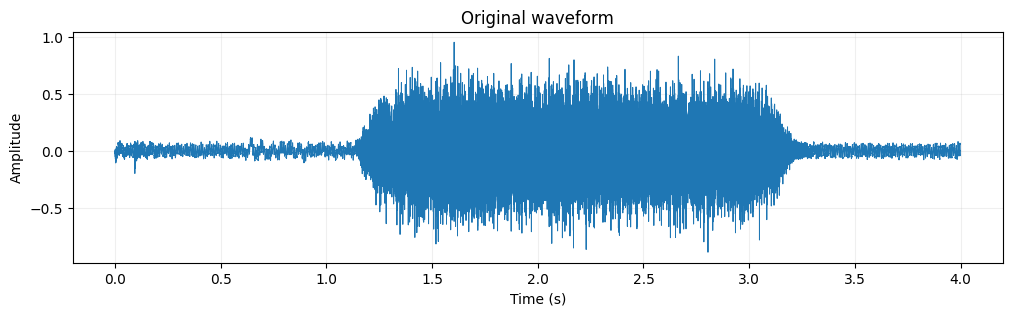

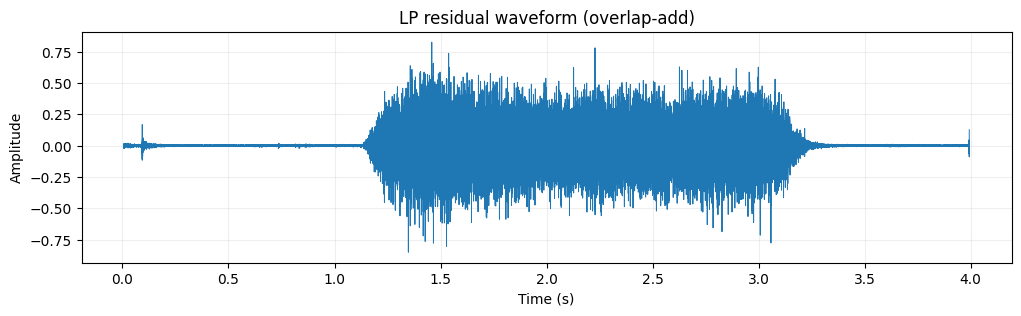

<Figure size 1200x400 with 0 Axes>

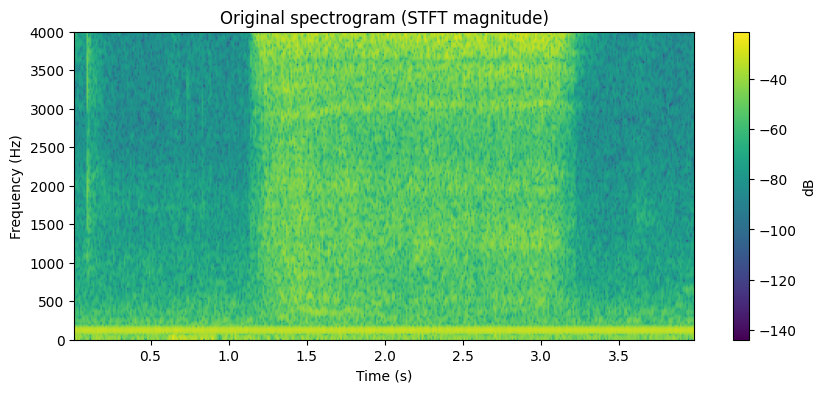

<Figure size 1200x400 with 0 Axes>

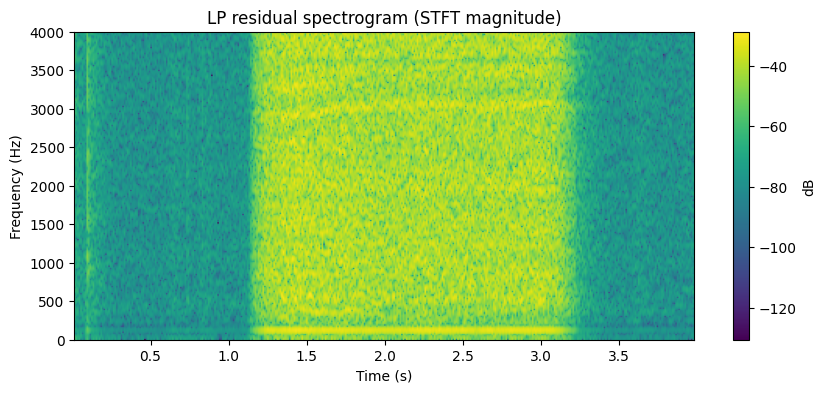

In [10]:

# Waveforms
t = np.arange(len(x)) / fs
t_res = np.arange(len(y_ola)) / fs

plt.figure(figsize=(12,3))
plt.plot(t, x, linewidth=0.7)
plt.title("Original waveform")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.2)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(t_res[100: -100], y_ola[100: -100], linewidth=0.7)
plt.title("LP residual waveform (overlap-add)")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.2)
plt.show()




# Spectrograms
plt.figure(figsize=(12,4))
# Z = stft_magphase(x, fs, win_ms=25, hop_ms=10, nfft=1024)[0]  # if your helper returns (Z, mag, phase) etc
# plot_spectrogram(Z, fs, title="Original spectrogram (STFT magnitude)")
plot_spectrogram(x, fs, title="Original spectrogram (STFT magnitude)")
plt.show()

plt.figure(figsize=(12,4))
# Z = stft_magphase(y_ola, fs, win_ms=25, hop_ms=10, nfft=1024)[0]  # if your helper returns (Z, mag, phase) etc
# plot_spectrogram(Z, fs, title="LP residual spectrogram (STFT magnitude")
plot_spectrogram(y_ola, fs, title="LP residual spectrogram (STFT magnitude)")
plt.show()


## 5. Vowel region: listen + inspect residual
If your manifest contains `vowel_frames`, we extract that region in samples and compare.

Vowel sample range: (23840, 28880) (0.315 s)
Original (vowel region):
 (fs=16000, length=0.32s)


LP residual (vowel region):
 (fs=16000, length=0.32s)


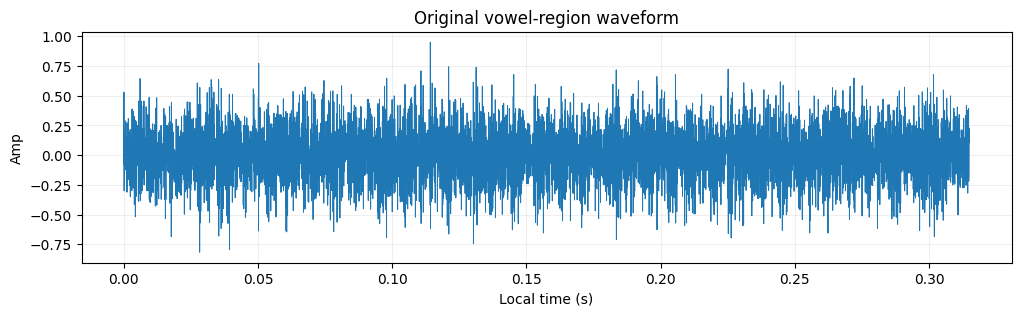

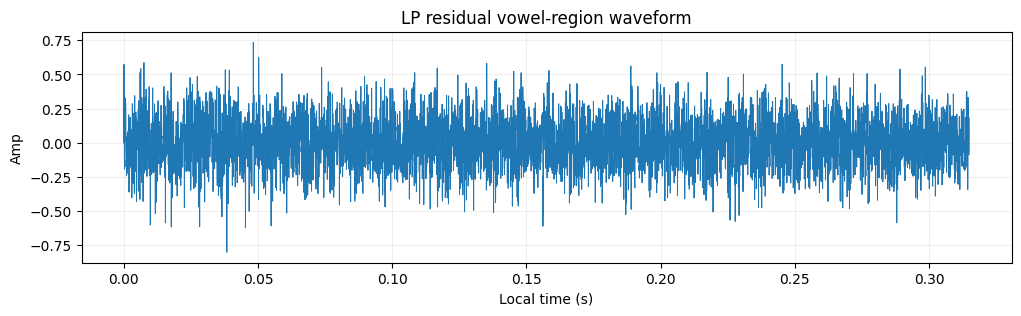

In [11]:

def frames_to_sample_range(frame_ids, N, H, fs):
    if len(frame_ids)==0:
        return None
    f0 = int(min(frame_ids))
    f1 = int(max(frame_ids))
    start = f0 * H
    end = f1 * H + N
    return start, end

rng = frames_to_sample_range(vowel_frames, N, H, fs)
if rng is None:
    print("No vowel_frames saved in manifest. (Run Notebook 9.0 selections.)")
else:
    s0, s1 = rng
    s0 = max(0, s0); s1 = min(len(x), s1)
    xv = x[s0:s1]
    yv = y_ola[s0:s1]
    print("Vowel sample range:", (s0, s1), f"({(s1-s0)/fs:.3f} s)")

    print("Original (vowel region):")
    play_audio(xv, fs)

    print("LP residual (vowel region):")
    play_audio(normalize_to_peak(yv), fs)

    plt.figure(figsize=(12,3))
    plt.plot(np.arange(len(xv))/fs, xv, linewidth=0.7)
    plt.title("Original vowel-region waveform")
    plt.xlabel("Local time (s)"); plt.ylabel("Amp"); plt.grid(True, alpha=0.2)
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(np.arange(len(yv))/fs, yv, linewidth=0.7)
    plt.title("LP residual vowel-region waveform")
    plt.xlabel("Local time (s)"); plt.ylabel("Amp"); plt.grid(True, alpha=0.2)
    plt.show()


## 6. LP spectrum for **all frames** → LP-spectrogram
For each frame we compute the magnitude response of the all-pole filter **1 / A(z)**.

**Interpretation:** The LP spectrum approximates the *vocal-tract spectral envelope* (especially in voiced vowel frames).

In [12]:

NFFT = 1024
n_freq = NFFT//2 + 1

lp_db = np.zeros((num_frames, n_freq), dtype=np.float64)
freq = np.linspace(0, fs/2, n_freq)

for i in range(num_frames):
    a = np.r_[1.0, a_all[i]]
    # all-pole envelope: H(e^jw) = 1 / A(e^jw)
    w_hz, h = sig.freqz(b=[1.0], a=a, worN=n_freq, fs=fs)
    mag = np.maximum(np.abs(h), 1e-12)
    lp_db[i] = 20*np.log10(mag)

# Time axis (frame centers)
t_frames = (np.arange(num_frames) * H + (N/2)) / fs

print("LP-spectrogram matrix:", lp_db.shape, "| time span:", (t_frames[0], t_frames[-1]), "s")


LP-spectrogram matrix: (398, 513) | time span: (np.float64(0.0125), np.float64(3.9825)) s


### 6A. 2D LP-spectrogram (like a spectrogram, but *model-based*)

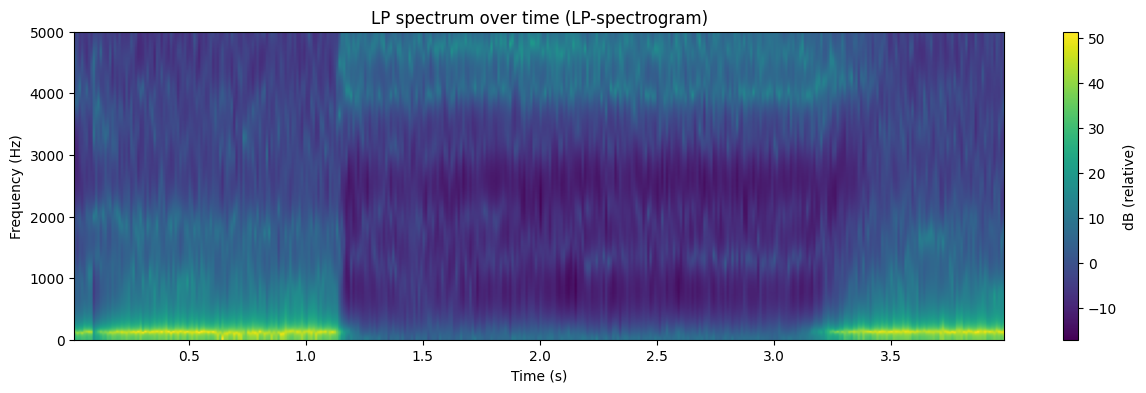

In [13]:

plt.figure(figsize=(15,4))
plt.imshow(lp_db.T, origin="lower", aspect="auto",
           extent=[t_frames[0], t_frames[-1], freq[0], freq[-1]])
plt.title("LP spectrum over time (LP-spectrogram)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="dB (relative)")
plt.ylim(0, min(5000, fs/2))
plt.show()


In [14]:
# ----------------------------
# 🎛️ Visualization range selection (for LP-spectrogram + 3D surface)
# ----------------------------
# Choose ONE:
#   VIS_MODE = "vowel"   -> uses manifest vowel_frames (recommended)
#   VIS_MODE = "fricative" / "silence"
#   VIS_MODE = "time"    -> uses VIS_T0_SEC .. VIS_T1_SEC
VIS_MODE = "vowel"

VIS_T0_SEC = 0.0     # only used if VIS_MODE="time"
VIS_T1_SEC = 1.0

MAX_FRAMES_3D = 120  # keep 3D plot light; increase if needed

def get_frame_list_from_mode(sel, mode):
    if mode == "vowel":
        return sel.get("vowel_frames", [])
    if mode == "fricative":
        return sel.get("fricative_frames", [])
    if mode == "silence":
        return sel.get("silence_frames", [])
    return []

# Determine which frames to visualize
frame_ids = []
if 'sel' in globals() and isinstance(sel, dict) and VIS_MODE in ["vowel","fricative","silence"]:
    frame_ids = get_frame_list_from_mode(sel, VIS_MODE)

if VIS_MODE in ["vowel","fricative","silence"] and len(frame_ids) > 0:
    f0 = int(np.min(frame_ids))
    f1 = int(np.max(frame_ids))
    vis_mask = (np.arange(num_frames) >= f0) & (np.arange(num_frames) <= f1)
    vis_desc = f"{VIS_MODE} frames [{f0}..{f1}]"
else:
    # time-based selection
    vis_mask = (t_frames >= VIS_T0_SEC) & (t_frames <= VIS_T1_SEC)
    vis_desc = f"time range [{VIS_T0_SEC:.3f}, {VIS_T1_SEC:.3f}] s"

idx_vis = np.where(vis_mask)[0]
if len(idx_vis) == 0:
    idx_vis = np.arange(num_frames)
    vis_desc = "FULL (fallback)"

print("Visualization:", vis_desc, "| frames:", len(idx_vis), "| t-span:", (t_frames[idx_vis[0]], t_frames[idx_vis[-1]]))

Visualization: vowel frames [149..178] | frames: 30 | t-span: (np.float64(1.5025), np.float64(1.7925))


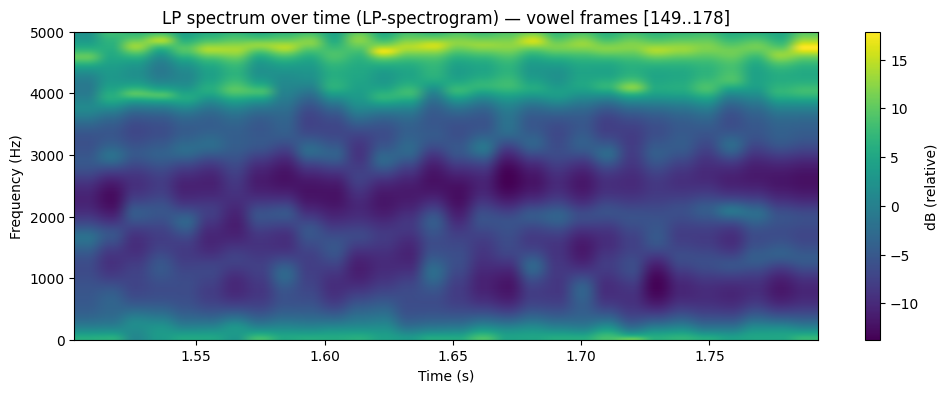

In [15]:
# ----------------------------
# 2D LP "spectrogram" (restricted to selected range)
# ----------------------------
lp_db_vis = lp_db[idx_vis]
t_vis = t_frames[idx_vis]

plt.figure(figsize=(12,4))
plt.imshow(lp_db_vis.T, origin="lower", aspect="auto",
           extent=[t_vis[0], t_vis[-1], freq[0], freq[-1]])
plt.title(f"LP spectrum over time (LP-spectrogram) — {vis_desc}")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="dB (relative)")
plt.ylim(0, min(5000, fs/2))
plt.show()

### 6B. Optional 3D surface (downsampled for speed)
If this is slow on your machine, reduce `T_DS` or `F_DS`.

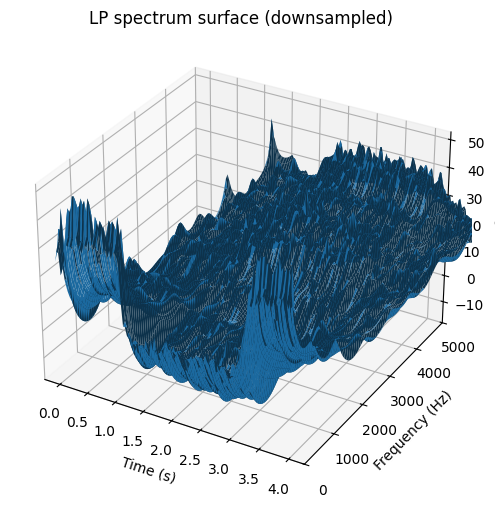

In [16]:

from mpl_toolkits.mplot3d import Axes3D  # noqa

T_DS = 3   # time downsample
F_DS = 4   # freq downsample

T = t_frames[::T_DS]
F = freq[::F_DS]
Z = lp_db[::T_DS, ::F_DS].T  # shape (F, T)

TT, FF = np.meshgrid(T, F)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(TT, FF, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax.set_title("LP spectrum surface (downsampled)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("dB")
ax.set_ylim(0, min(5000, fs/2))
plt.show()


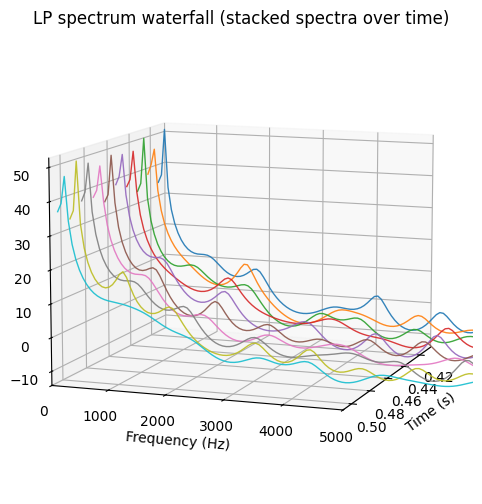

In [17]:
from mpl_toolkits.mplot3d import Axes3D  # noqa

# ---- pick a small time region (either indices or time mask) ----
i0, i1 = 40, 50                      # frames
lp_db_small = lp_db[i0:i1, :]        # (time, freq)
t_small = t_frames[i0:i1]

# ---- downsample for nicer plotting ----
T_DS = 1
F_DS = 4

T = t_small[::T_DS]
F = freq[::F_DS]
Z = lp_db_small[::T_DS, ::F_DS]      # shape (T, F)

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111, projection='3d')

# Waterfall: one line per time frame
for k, t in enumerate(T):
    ax.plot(
        np.full_like(F, t),   # X = time (constant for this line)
        F,                    # Y = frequency
        Z[k, :],              # Z = dB spectrum at that time
        linewidth=1.0,
        alpha=0.9
    )

ax.set_title("LP spectrum waterfall (stacked spectra over time)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("dB")
ax.set_ylim(0, min(5000, fs/2))

# ---- tilt / camera angle ----
ax.view_init(elev=10, azim=20)   # try elev=15..40, azim=-120..0

# Optional: make aspect look less “squished”
# ax.set_box_aspect((2.0, 2.0, 1.0))  # (time, freq, dB) - needs newer matplotlib

plt.show()

## 7. Sanity check: LP envelope vs FFT magnitude (pick a frame)
Pick a vowel frame (or any frame) and overlay FFT magnitude and LP envelope.

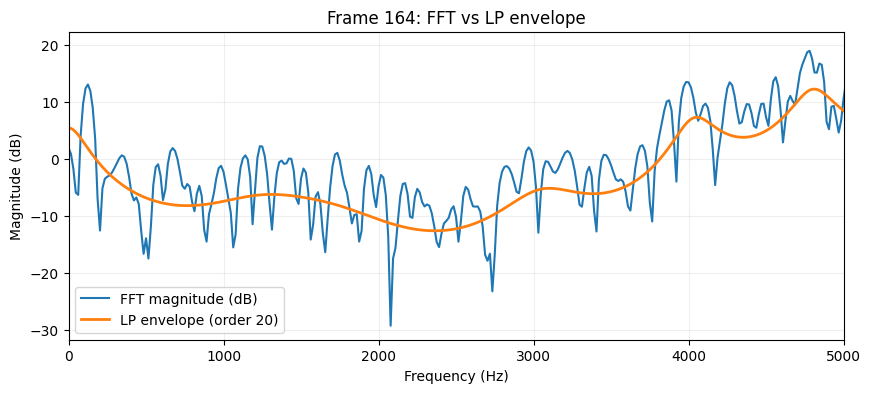

In [18]:

FRAME_TO_PLOT = vowel_frames[len(vowel_frames)//2] if len(vowel_frames)>0 else 0
frame = frames[FRAME_TO_PLOT]
a = np.r_[1.0, a_all[FRAME_TO_PLOT]]

f_fft, X_db = fft_mag_db(frame, fs, nfft=NFFT)
f_lp, lp1_db = sig.freqz(b=[1.0], a=a, worN=n_freq, fs=fs)
lp1_db = 20*np.log10(np.maximum(np.abs(lp1_db), 1e-12))

plt.figure(figsize=(10,4))
plt.plot(f_fft, X_db, label="FFT magnitude (dB)")
plt.plot(f_lp, lp1_db, label=f"LP envelope (order {P})", linewidth=2)
plt.title(f"Frame {FRAME_TO_PLOT}: FFT vs LP envelope")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, min(5000, fs/2))
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()


## Save a couple of key figures (optional)
This uses the same `savefig()` helper as earlier notebooks.

In [ ]:

# # Example saves (uncomment if you want)
# plt.figure(figsize=(12,4))
# plt.imshow(lp_db.T, origin="lower", aspect="auto",
#            extent=[t_frames[0], t_frames[-1], freq[0], freq[-1]])
# plt.title("LP spectrum over time (LP-spectrogram)")
# plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
# plt.ylim(0, min(5000, fs/2)); plt.colorbar(label="dB (relative)")
# savefig(FIG_DIR / "L9_5_LP_spectrogram.png")
# plt.show()


## ✅ Reflection questions
1. In your LP residual spectrogram, what remains strongest: harmonic structure, noise bursts, or transitions?
2. For vowels vs fricatives, which has a ‘cleaner’ all-pole LP-spectrogram? Why?
3. How does LPC order `P` affect (a) residual quality and (b) envelope smoothness?
4. In what sense is LP-spectrogram a *model-based* alternative to STFT magnitude spectrogram?


### Answers

1. The harmonic structure remained the strongest.
2. Vowels do because they better fit the all-pole assumption.
3. a: As p increases we remove spectral structure, but if its too high we get distorted residuals.
   b: As p increases the envelope becomes flatter and we see less peaks.
4. LP spectrogram has parameters while STFT is based off the data. The STFT shows raw frequencies while LP represents with low parameter filter.